### Reinforcement Learning - Robô Investidor

https://pypi.org/project/bayesian-optimization/

In [1]:
# !pip install -q bayesian-optimization==1.4.3 --upgrade

In [2]:
# !pip install -q -U watermark

In [3]:
import pandas as pd
import numpy as np
np.float = float

import time
import random

import yfinance as yf

import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from datetime import datetime

In [4]:
%reload_ext watermark
%watermark -a "Robô Investidor"
%watermark --iversions

Author: Robô Investidor

matplotlib: 3.9.2
numpy     : 1.26.4
pandas    : 2.2.3
yfinance  : 0.2.55



### Download dos Dados
Execute o comando abaixo modificando o Ticker se quiser avaliar outros dados.

In [5]:
# symbol = "ITUB4.SA"
# start_date = "2005-01-03"
# end_date = "2025-03-30"

# df = yf.download(symbol, start=start_date, end=end_date)
# df.index = pd.to_datetime(df.index)
# display(df.head())
# print()
# display(df.tail())
# print(df.shape)
# print('##############################################################')

# cols = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# df = df.reset_index()
# df.columns = cols

# df.to_csv('datasets/itau.csv', index=False)

In [6]:
df = pd.read_csv('datasets/itau.csv', usecols=['Date','Close'], index_col='Date', parse_dates=['Date'])

In [7]:
df.head(10)

,Close
Date,
2005-01-03,3.161210
2005-01-04,3.122393
2005-01-05,3.091405
2005-01-06,3.052664
2005-01-07,3.048790
2005-01-10,3.068082
2005-01-11,3.027096
2005-01-12,2.982932
2005-01-13,3.068160


In [8]:
def preencher_finais_de_semana(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df.asfreq('D')                # Cria os dias ausentes
    df['Close'] = df['Close'].ffill() # Preenche com o último valor
    return df

In [9]:
df = preencher_finais_de_semana(df)

In [10]:
df.head(10)

,Close
Date,
2005-01-03,3.161210
2005-01-04,3.122393
2005-01-05,3.091405
2005-01-06,3.052664
2005-01-07,3.048790
2005-01-08,3.048790
2005-01-09,3.048790
2005-01-10,3.068082
2005-01-11,3.027096


In [11]:
df.shape

(7390, 1)

Text(0, 0.5, 'ITAU')

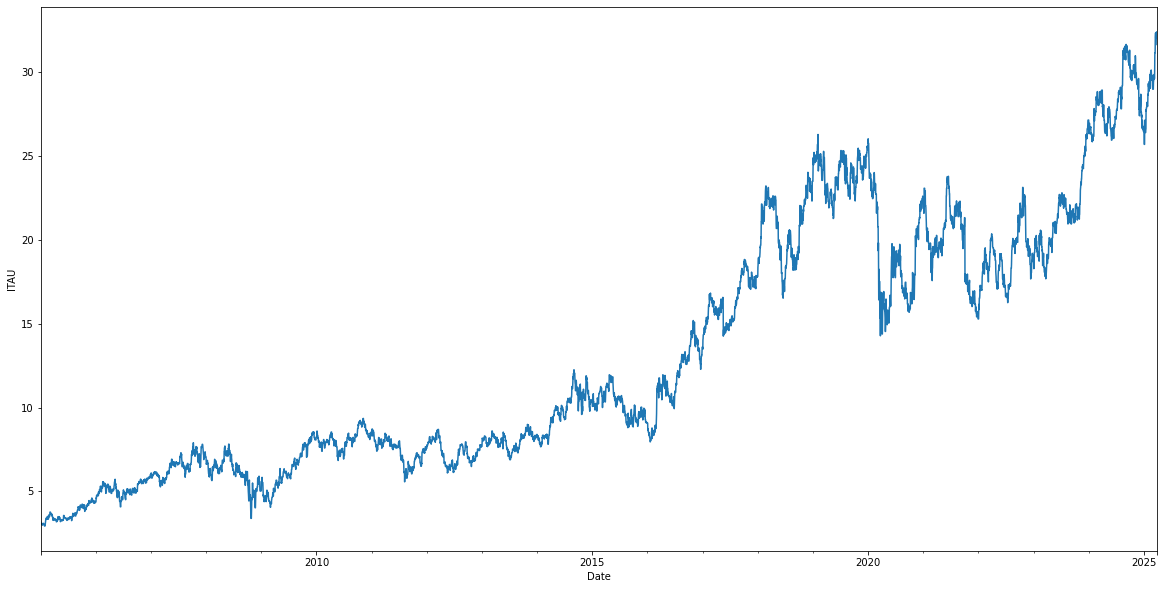

In [12]:
plt.figure(figsize = (20,10))
df['Close'].plot()
plt.ylabel('ITAU')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7390 entries, 2005-01-03 to 2025-03-28
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   7390 non-null   float64
dtypes: float64(1)
memory usage: 115.5 KB


In [14]:
display(df.head())
print(df.shape)

,Close
Date,
2005-01-03,3.161210
2005-01-04,3.122393
2005-01-05,3.091405
2005-01-06,3.052664
2005-01-07,3.048790


(7390, 1)


In [15]:
price = df.Close.values.tolist()

In [16]:
window_size = 30 # Os últimos 30 preços
skip = 5 # Decisão a cada 5 dias
l = len(price) - 1 # Marca o último índice válido da lista de preços

### Referências para o Treinamento

https://arxiv.org/pdf/1703.03864

https://arxiv.org/pdf/1712.06560

### Treina os pesos para otimização

In [17]:
class PoliticaTrader:
    inputs = None

    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def get_weights_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def treinamento(self, epoch=100, print_every=1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for _ in range(self.population_size):
                x = [np.random.randn(*w.shape) for w in self.weights]
                population.append(x)
            for k in range(self.population_size):
                weights_population = self.get_weights_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = w + (self.learning_rate / (self.population_size * self.sigma)) * np.dot(A.T, rewards).T
            if (i + 1) % print_every == 0:
                print(f"Iteração {i + 1} - Recompensa: {self.reward_function(self.weights):.6f}")
        print(f"Tempo total de treinamento: {time.time() - lasttime:.2f} segundos")

### Arquitetura da Rede Neural

In [18]:
class Modelo:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

### Confere o estado atual do comportamento dos preços

In [19]:
def get_state(price_data, current_index, window_size):
    start = current_index - window_size + 1
    window = price_data[start : current_index + 1] if start >= 0 else -start * [price_data[0]] + price_data[0 : current_index + 1]
    differences = []
    for i in range(window_size - 1):
        differences.append(window[i + 1] - window[i])
    return np.array([differences])

### Construção do Agente que vai realizar as operações

In [20]:
class Trader:
    def __init__(self, population_size, sigma, learning_rate, model, money, max_buy, max_sell, skip, window_size):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = PoliticaTrader(self.model.get_weights(),
                                 self.get_reward,
                                 self.POPULATION_SIZE,
                                 self.SIGMA,
                                 self.LEARNING_RATE)

    def agir(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(price, 0, self.window_size + 1)
        inventory = []
        quantity = 0

        for t in range(0, l, self.skip):
            action, buy = self.agir(state)
            next_state = get_state(price, t + 1, self.window_size + 1)

            if action == 1 and initial_money >= price[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy

                total_buy = buy_units * price[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units

            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity

                quantity -= sell_units
                total_sell = sell_units * price[t]
                initial_money += total_sell

            state = next_state

        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.treinamento(iterations, print_every=checkpoint)

    def investir(self):
        initial_money = self.initial_money
        starting_money = initial_money
        state = get_state(price, 0, self.window_size + 1)
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0

        for t in range(0, l, self.skip):
            action, buy = self.agir(state)
            next_state = get_state(price, t + 1, self.window_size + 1)

            if action == 1 and initial_money >= price[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy

                total_buy = buy_units * price[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)

                print(f'Dia {t}: comprar {buy_units} unidades ao preço de {total_buy:.2f}, saldo total {initial_money:.2f}')

            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue

                quantity -= sell_units
                total_sell = sell_units * price[t]
                initial_money += total_sell
                states_sell.append(t)

                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0

                print(f'Dia {t}, vender {sell_units} unidades ao preço de {total_sell:.2f}, investimento {invest:.2f} %, saldo total {initial_money:.2f}')

            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(f'\nGanho Total {initial_money - starting_money:.2f}, Valor Total Investido {invest:.2f}')

        plt.figure(figsize=(20, 10))
        plt.plot(price, label='Valor Real de Fechamento', c='g')
        plt.plot(price, 'X', label='Previsão de Compra', markevery=states_buy, c='b')
        plt.plot(price, 'o', label='Previsão de Venda', markevery=states_sell, c='r')
        plt.legend()
        plt.show()

### Busca o Melhor Trader

- window_size:	Quanto do histórico o agente observa
- skip:	Frequência das decisões
- population_size:	Quantas políticas são testadas por geração
- sigma:	Quanto ruído (exploração) é aplicado
- learning_rate:	Velocidade de aprendizado
- size_network:	Tamanho da rede neural usada pelo trader

In [21]:
def melhor_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    model = Modelo(window_size, size_network, 3)
    trader = Trader(population_size, sigma, learning_rate, model, 10000, 100, 100, skip, window_size)
    try:
        trader.fit(100, 1000)
        return trader.es.reward_function(trader.es.weights)
    except:
        return 0

In [22]:
def busca_melhor_trader(window_size, skip, population_size, sigma, learning_rate, size_network):

    parametros = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }

    print(f"\nBuscando Parâmetros {parametros}")
    investimento = melhor_trader(**parametros)
    print(f"Após 100 iterações o investimento foi de {investimento:.2f}")
    return investimento

### Otimização Bayesiana

In [23]:
otimizacao_bayesiana = BayesianOptimization(busca_melhor_trader, {'window_size': (2, 50),
                                                                  'skip': (1, 15),
                                                                  'population_size': (1, 50),
                                                                  'sigma': (0.01, 0.99),
                                                                  'learning_rate': (0.000001, 0.49),
                                                                  'size_network': (10, 1000),},)

- init_points: Exploração inicial aleatória
- n_iter: Otimização bayesiana

In [24]:
%%time
otimizacao_bayesiana.maximize(init_points = 10, n_iter = 10)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Buscando Parâmetros {'window_size': 4, 'skip': 2, 'population_size': 31, 'sigma': 0.024258436468151963, 'learning_rate': 0.331419851619521, 'size_network': 229}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])
C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\2855685633.py:32: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.00
| 1         | 0.0       | 0.3314    | 30.6      | 0.02426   | 229.4     | 2.171     | 4.261     |

Buscando Parâmetros {'window_size': 15, 'skip': 13, 'population_size': 49, 'sigma': 0.6800658352558826, 'learning_rate': 0.42816641305200104, 'size_network': 484}
Tempo total de treinamento: 54.23 segundos
Após 100 iterações o investimento foi de 245.97
| 2         | 246.0     | 0.4282    | 49.39     | 0.6801    | 484.2     | 12.58     | 15.38     |

Buscando Parâmetros {'window_size': 3, 'skip': 13, 'population_size': 17, 'sigma': 0.9116158364444853, 'learning_rate': 0.4762301372624611, 'size_network': 54}
Tempo total de treinamento: 13.27 segundos
Após 100 iterações o investimento foi de 32.72
| 3         | 32.72     | 0.4762    | 17.27     | 0.9116    | 54.34     | 13.36     | 2.815     |

Buscando Parâmetros {'window_size': 38, 'skip': 9, 'population_size': 28, 'sigma': 0.8465307964228516, 'learning_rate': 0.3948277663922458, 'size_network

C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])
C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\2855685633.py:32: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.00
| 11        | 0.0       | 0.4854    | 9.181     | 0.03834   | 338.2     | 4.146     | 11.8      |

Buscando Parâmetros {'window_size': 48, 'skip': 3, 'population_size': 25, 'sigma': 0.3459756245860737, 'learning_rate': 0.39876156529421275, 'size_network': 283}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 1018.29 segundos
Após 100 iterações o investimento foi de 603.24
| 12        | 603.2     | 0.3988    | 24.51     | 0.346     | 283.1     | 3.024     | 47.86     |

Buscando Parâmetros {'window_size': 34, 'skip': 11, 'population_size': 17, 'sigma': 0.6208645673900188, 'learning_rate': 0.46058003995620694, 'size_network': 114}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 23.70 segundos
Após 100 iterações o investimento foi de 517.27
| 13        | 517.3     | 0.4606    | 17.42     | 0.6209    | 114.4     | 11.03     | 34.23     |

Buscando Parâmetros {'window_size': 24, 'skip': 2, 'population_size': 32, 'sigma': 0.6198305158875494, 'learning_rate': 1e-06, 'size_network': 283}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 255.11 segundos
Após 100 iterações o investimento foi de -9.48
| 14        | -9.479    | 1e-06     | 31.88     | 0.6198    | 283.2     | 1.791     | 24.25     |

Buscando Parâmetros {'window_size': 23, 'skip': 11, 'population_size': 24, 'sigma': 0.7719503436190507, 'learning_rate': 0.17253035285046545, 'size_network': 866}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 259.07 segundos
Após 100 iterações o investimento foi de 39.15
| 15        | 39.15     | 0.1725    | 23.61     | 0.772     | 865.8     | 11.02     | 22.5      |

Buscando Parâmetros {'window_size': 18, 'skip': 8, 'population_size': 16, 'sigma': 0.7484168971223226, 'learning_rate': 0.26205760171118764, 'size_network': 369}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 32.45 segundos
Após 100 iterações o investimento foi de 51.84
| 16        | 51.84     | 0.2621    | 16.48     | 0.7484    | 368.9     | 8.376     | 17.73     |

Buscando Parâmetros {'window_size': 35, 'skip': 13, 'population_size': 16, 'sigma': 0.7888738767830474, 'learning_rate': 0.29019097731321036, 'size_network': 653}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 149.90 segundos
Após 100 iterações o investimento foi de 505.43
| 17        | 505.4     | 0.2902    | 15.81     | 0.7889    | 653.1     | 13.12     | 34.73     |

Buscando Parâmetros {'window_size': 42, 'skip': 10, 'population_size': 14, 'sigma': 0.5481364440218971, 'learning_rate': 0.2088982902265291, 'size_network': 844}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 180.80 segundos
Após 100 iterações o investimento foi de 608.19
| 18        | 608.2     | 0.2089    | 13.89     | 0.5481    | 843.6     | 9.726     | 42.16     |

Buscando Parâmetros {'window_size': 9, 'skip': 3, 'population_size': 24, 'sigma': 0.7659116292900088, 'learning_rate': 0.42521215390733696, 'size_network': 790}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 119.03 segundos
Após 100 iterações o investimento foi de 376.83
| 19        | 376.8     | 0.4252    | 23.62     | 0.7659    | 790.4     | 3.105     | 9.266     |

Buscando Parâmetros {'window_size': 23, 'skip': 12, 'population_size': 8, 'sigma': 0.381504733839809, 'learning_rate': 0.03511613355793625, 'size_network': 909}


C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 82.84 segundos
Após 100 iterações o investimento foi de 302.48
| 20        | 302.5     | 0.03512   | 8.213     | 0.3815    | 909.0     | 12.02     | 23.28     |
CPU times: total: 1h 1min 39s
Wall time: 1h 2min 4s


In [25]:
otimizacao_bayesiana.res

[{'target': 0.0,
  'params': {'learning_rate': 0.331419851619521,
   'population_size': 30.595869172992415,
   'sigma': 0.024258436468151963,
   'size_network': 229.39347573721216,
   'skip': 2.1707653753102947,
   'window_size': 4.260930255795852}},
 {'target': 245.96811668634416,
  'params': {'learning_rate': 0.42816641305200104,
   'population_size': 49.38677577250064,
   'sigma': 0.6800658352558826,
   'size_network': 484.24295024707436,
   'skip': 12.577757825240578,
   'window_size': 15.384626460027375}},
 {'target': 32.71652614116668,
  'params': {'learning_rate': 0.4762301372624611,
   'population_size': 17.268449754694217,
   'sigma': 0.9116158364444853,
   'size_network': 54.33647147601505,
   'skip': 13.356917045952846,
   'window_size': 2.815311165301855}},
 {'target': 673.8221340417862,
  'params': {'learning_rate': 0.3948277663922458,
   'population_size': 27.970996140272643,
   'sigma': 0.8465307964228516,
   'size_network': 677.9758725244288,
   'skip': 9.20998377240840

In [26]:
max([dic['target'] for dic in otimizacao_bayesiana.res])

1370.819258351326

In [27]:
[dic['params'] for dic in otimizacao_bayesiana.res]

[{'learning_rate': 0.331419851619521,
  'population_size': 30.595869172992415,
  'sigma': 0.024258436468151963,
  'size_network': 229.39347573721216,
  'skip': 2.1707653753102947,
  'window_size': 4.260930255795852},
 {'learning_rate': 0.42816641305200104,
  'population_size': 49.38677577250064,
  'sigma': 0.6800658352558826,
  'size_network': 484.24295024707436,
  'skip': 12.577757825240578,
  'window_size': 15.384626460027375},
 {'learning_rate': 0.4762301372624611,
  'population_size': 17.268449754694217,
  'sigma': 0.9116158364444853,
  'size_network': 54.33647147601505,
  'skip': 13.356917045952846,
  'window_size': 2.815311165301855},
 {'learning_rate': 0.3948277663922458,
  'population_size': 27.970996140272643,
  'sigma': 0.8465307964228516,
  'size_network': 677.9758725244288,
  'skip': 9.209983772408401,
  'window_size': 37.95814358604853},
 {'learning_rate': 0.16385121568010222,
  'population_size': 37.174272433623706,
  'sigma': 0.8961281036216596,
  'size_network': 430.354

In [28]:
print(f"Learning Rate: {max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])}")
print(f"Population Size: {max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])}")
print(f"Sigma: {max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])}")
print(f"Size Network: {max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])}")
print(f"Skip: {max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])}")
print(f"Window Size: {max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])}")

Learning Rate: 0.48543309412110164
Population Size: 49.38677577250064
Sigma: 0.9397873675507651
Size Network: 908.969783907736
Skip: 14.852900222693126
Window Size: 47.86001041133588


### Execução do Bot

In [29]:
%%time
melhor_trader(window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
              skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
              population_size = int(max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])), 
              sigma = max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
              learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
              size_network = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))))

C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Tempo total de treinamento: 425.39 segundos
CPU times: total: 7min 9s
Wall time: 7min 5s


561.8798980474472

In [30]:
%%time
modelo_otim = Modelo(input_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     layer_size = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     output_size = 3)

CPU times: total: 0 ns
Wall time: 984 µs


In [31]:
trader_otim = Trader(population_size = int(np.around(max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     sigma = max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
                     learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
                     model = modelo_otim, 
                     money = 10000, 
                     max_buy = 100, 
                     max_sell = 100, 
                     skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))))

In [32]:
%%time
trader_otim.fit(1000, 100)

C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


Iteração 100 - Recompensa: 516.903928
Iteração 200 - Recompensa: 566.555376
Iteração 300 - Recompensa: 591.611814
Iteração 400 - Recompensa: 607.779532
Iteração 500 - Recompensa: 670.518645
Iteração 600 - Recompensa: 743.902229
Iteração 700 - Recompensa: 742.509109
Iteração 800 - Recompensa: 766.039664
Iteração 900 - Recompensa: 784.344795
Iteração 1000 - Recompensa: 778.338104
Tempo total de treinamento: 4316.12 segundos
CPU times: total: 1h 12min 23s
Wall time: 1h 11min 56s


Dia 0: comprar 100 unidades ao preço de 316.12, saldo total 9683.88
Dia 15: comprar 100 unidades ao preço de 303.72, saldo total 9380.16
Dia 30: comprar 100 unidades ao preço de 316.89, saldo total 9063.27
Dia 45: comprar 100 unidades ao preço de 346.33, saldo total 8716.94
Dia 60: comprar 100 unidades ao preço de 376.55, saldo total 8340.40
Dia 75: comprar 100 unidades ao preço de 354.08, saldo total 7986.32
Dia 90: comprar 100 unidades ao preço de 336.26, saldo total 7650.06
Dia 105: comprar 100 unidades ao preço de 322.31, saldo total 7327.75
Dia 120: comprar 100 unidades ao preço de 334.95, saldo total 6992.80
Dia 135: comprar 100 unidades ao preço de 331.60, saldo total 6661.20
Dia 150: comprar 100 unidades ao preço de 356.40, saldo total 6304.80
Dia 165: comprar 100 unidades ao preço de 339.82, saldo total 5964.98
Dia 180: comprar 100 unidades ao preço de 340.13, saldo total 5624.84
Dia 195: comprar 100 unidades ao preço de 342.88, saldo total 5281.96
Dia 210: comprar 100 unidade

C:\Users\ariel\AppData\Local\Temp\ipykernel_18392\700157817.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


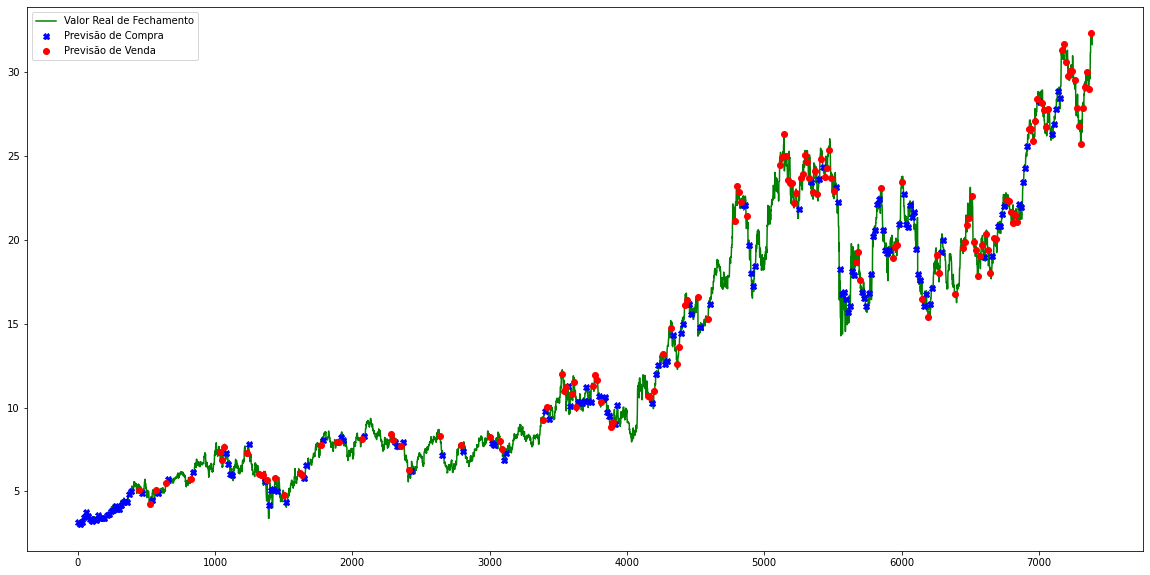

CPU times: total: 438 ms
Wall time: 372 ms


In [33]:
%%time
trader_otim.investir()